# To determine what features will best predict cpu/event

we'll calculate averages of cpu/event per CPU and processing type and use that dummy predictor
we'll fit separately fastBmk, bogomips, hs06, whetstone to cpu/event for each processing type adn use that as a predictor

compare all 5.


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score


### Get datasets

In [2]:
jobs = pd.read_csv('job.csv').set_index('pandaid')
jobs = jobs[jobs['inputsize']>1024]
jobs['cpuPerMB']= jobs['cputime']/(jobs['inputsize']/1024./1024.)
del jobs['cputime']
del jobs['walltime']
del jobs['nevents']
del jobs['cpueff']
del jobs['wallPerEvent']
del jobs['inputsize']

jobs.head()

,hs06,processingtype,cpuPerEvent,cpuPerMB
pandaid,,,,
3352703758,107,recon,4.436667,110.248904
3354732793,10,evgen,1.100000,652.003663
3326375042,96,reprocessing,12.623182,11.807224
3327803396,77,merge,0.358200,1.053848
3330689156,90,merge,0.337855,1.132681


In [3]:
benchmarks = pd.read_csv('benchmark.csv').set_index('pandaid')

print(benchmarks.columns)

del benchmarks['ip']
del benchmarks['site']
del benchmarks['meminfo']

print(benchmarks.columns)

benchmarks.head()

Index(['bogomips', 'ip', 'site', 'mpnum', 'cpuname', 'meminfo', 'fastBmk',
       'whetstone'],
      dtype='object')
Index(['bogomips', 'mpnum', 'cpuname', 'fastBmk', 'whetstone'], dtype='object')


,bogomips,mpnum,cpuname,fastBmk,whetstone
pandaid,,,,,
3322806223,5333.52,1,QEMU Virtual CPU version (cpu64-rhel6),9.223674,3195.99
3357390345,4988.44,8,Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz,12.610536,3101.83
3322633663,5000.00,1,Intel(R) Xeon(R) CPU E5420 @ 2.50GHz,12.129380,2749.34
3357339988,4988.44,8,Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz,17.159994,3377.43
3322488785,4988.06,1,Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz,23.731048,3599.70


### join dataframes and filter out bad rows

In [4]:
benchmarks = benchmarks.join(jobs,how='inner')
benchmarks = benchmarks[benchmarks.cpuPerMB > 0]
benchmarks = benchmarks[benchmarks.mpnum == 1]

del benchmarks['mpnum']

benchmarks.head()

,bogomips,cpuname,fastBmk,whetstone,hs06,processingtype,cpuPerEvent,cpuPerMB
pandaid,,,,,,,,
3323737831,5199.28,Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz,14.863749,3612.79,10,simul,73.644,401.351564
3323782011,5199.25,Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz,14.869888,3628.96,10,evgen,154.110,412.060215
3323782017,4189.98,Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz,18.136020,3306.22,10,evgen,159.280,425.883791
3323788151,5199.24,Intel(R) Xeon(R) CPU E5-2640 v3 @ 2.60GHz,20.642202,3495.29,10,evgen,167.210,447.087071
3323820043,4787.82,Intel(R) Xeon(R) CPU E5620 @ 2.40GHz,6.792453,1532.55,13,evgen,426.825,1141.349308


### split over different processing types 

In [5]:
UniqueProcessingTypes = benchmarks.processingtype.unique()
print(UniqueProcessingTypes)
UniqueProcessingTypes=UniqueProcessingTypes.tolist()

# UniqueProcessingTypes.remove('overlay')
# UniqueProcessingTypes.remove('deriv')

#create a dict for all the dataframes to be filled later
ProcessingType = {elem : pd.DataFrame for elem in UniqueProcessingTypes}

#filling up data frames
for key in ProcessingType.keys():
    ProcessingType[key] = benchmarks[:][benchmarks.processingtype == key]
    

['simul' 'evgen' 'reprocessing' 'merge' 'eventIndex' 'pmerge' 'recon'
 'pile' 'overlay']


### plot correlations

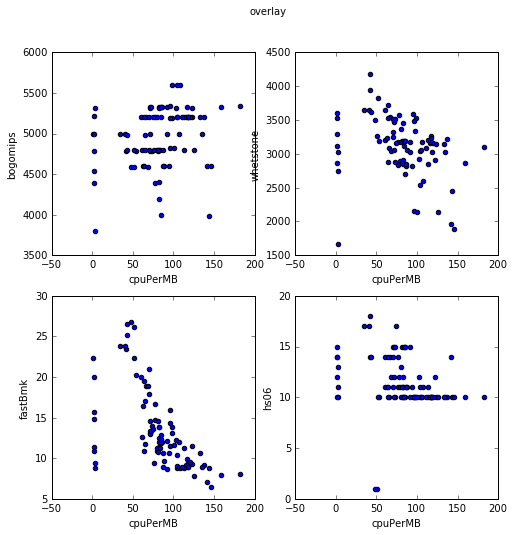

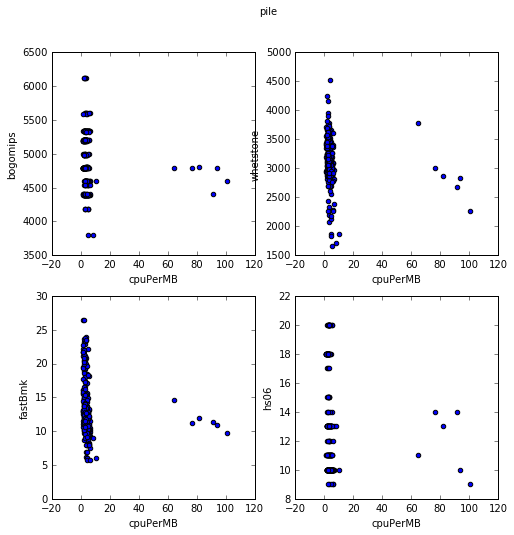

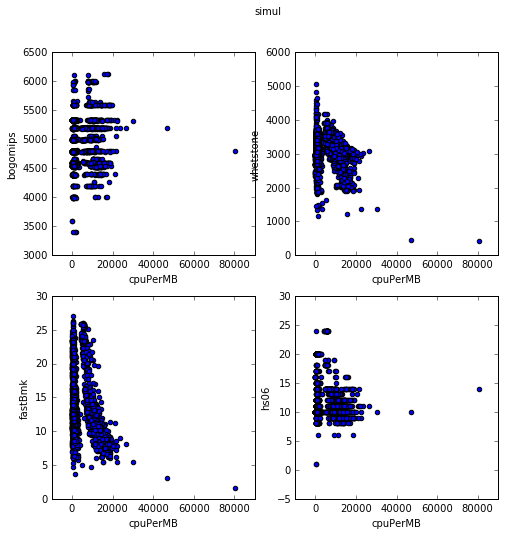

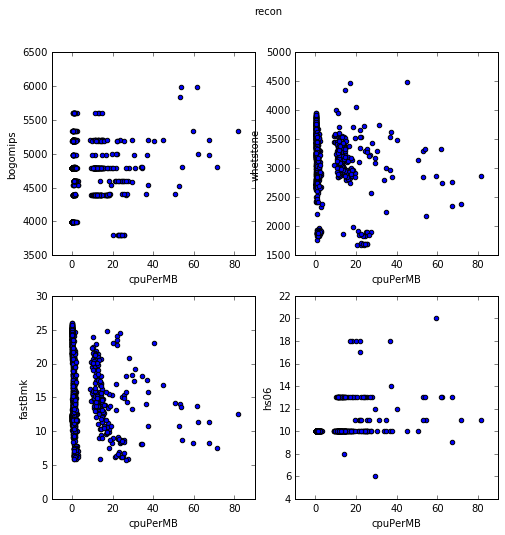

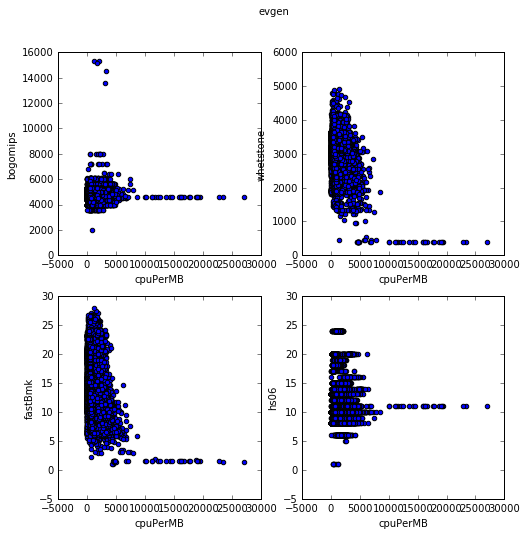

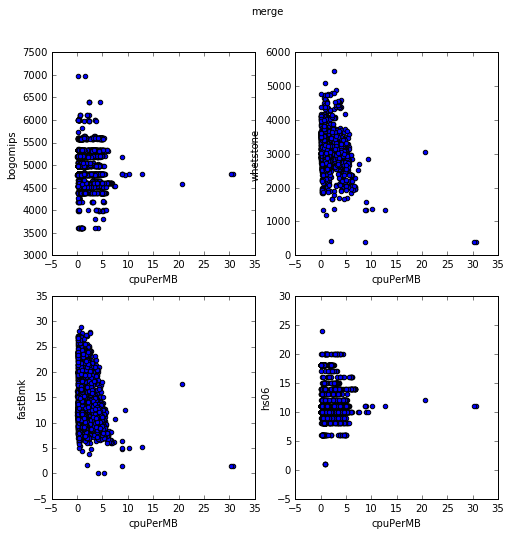

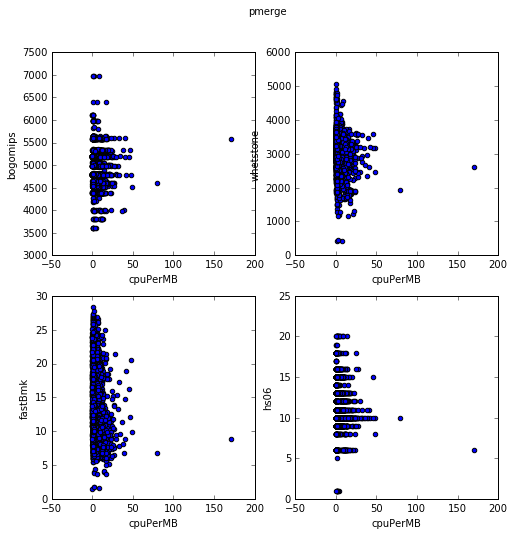

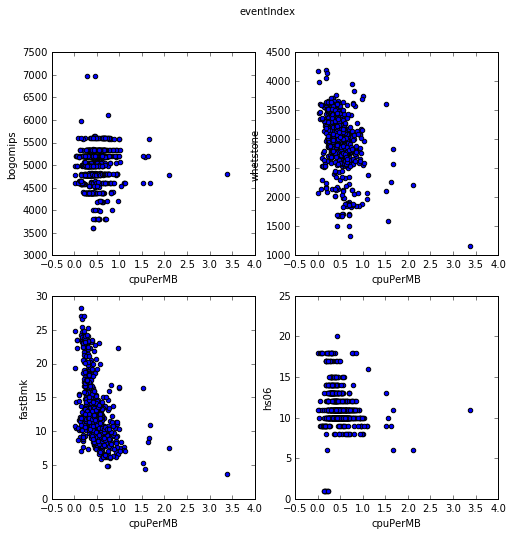

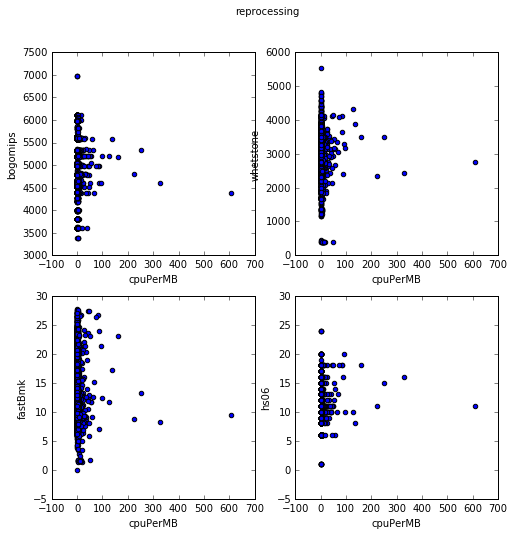

In [7]:
feat = ['bogomips', 'fastBmk', 'whetstone', 'hs06']
for pt in ProcessingType.keys():
    fig, axes = plt.subplots(nrows=2, ncols=2)
    plt.suptitle(pt)
    data = ProcessingType[pt]
    for nf, f in enumerate(feat):
        i = nf%2
        j = int(nf/2)
        data.plot(ax=axes[i,j], x="cpuPerMB", y=f, kind='scatter',figsize=(8, 8)) 

### split on training and testing samples

===========  overlay =============
(72, 6) (72, 1) (19, 6) (19, 1)
***  bogomips  ***
cross validation score:  -1.26842712791
	evs: 0.0102 	mae:    35.3596 	mse:  1928.9436 	r2:    0.0100
***  fastBmk  ***
cross validation score:  -0.504225990861
	evs: 0.3156 	mae:    25.6824 	mse:  1397.7779 	r2:    0.2826
***  whetstone  ***
cross validation score:  -1.29177463144
	evs: 0.1200 	mae:    31.4632 	mse:  1724.0853 	r2:    0.1151
***  hs06  ***
cross validation score:  -1.25779122604
	evs: 0.0343 	mae:    35.6698 	mse:  1882.3676 	r2:    0.0339
Describe predictions
            actual   bogomips     fastBmk       hs06   whetstone
count   19.000000  19.000000   19.000000  19.000000   19.000000
mean    81.917526  82.502992   89.940229  81.045502   85.010639
std     45.350138   8.401985   18.189718   8.579264   10.588153
min      1.973444  65.923602   39.174675  61.706877   69.500419
25%     62.696388  77.297367   87.641039  76.258714   80.725884
50%     85.798119  83.070936   92.969830  83.5

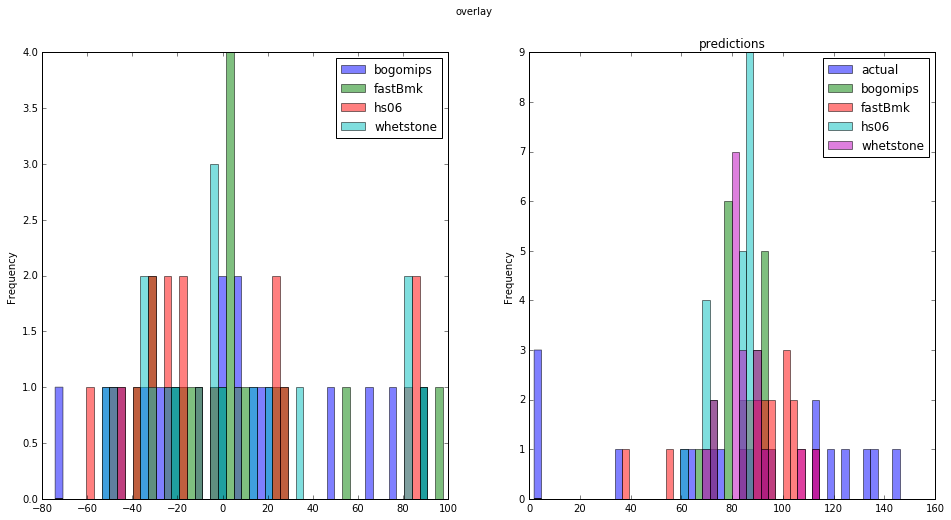

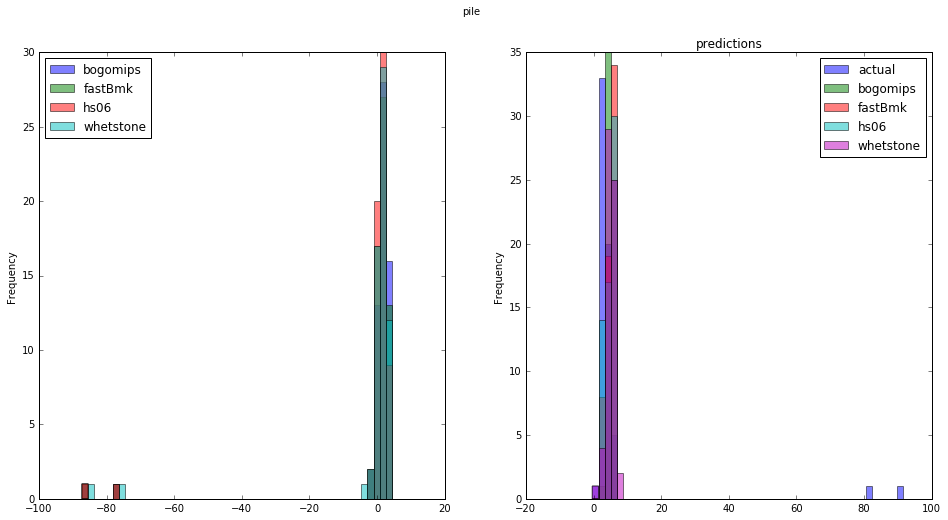

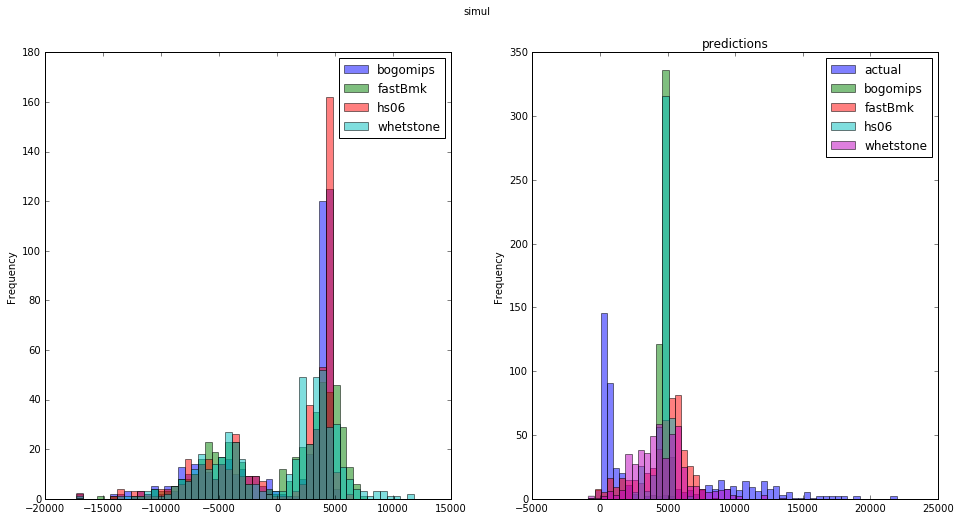

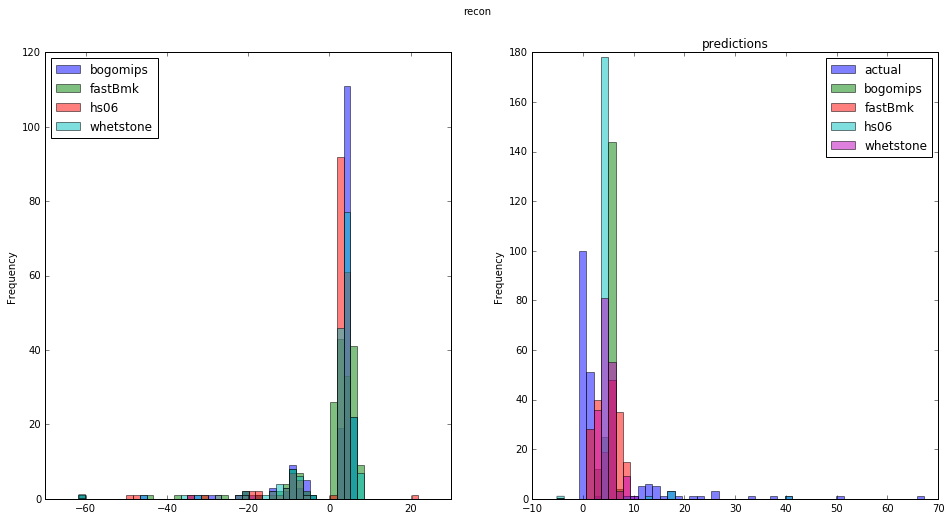

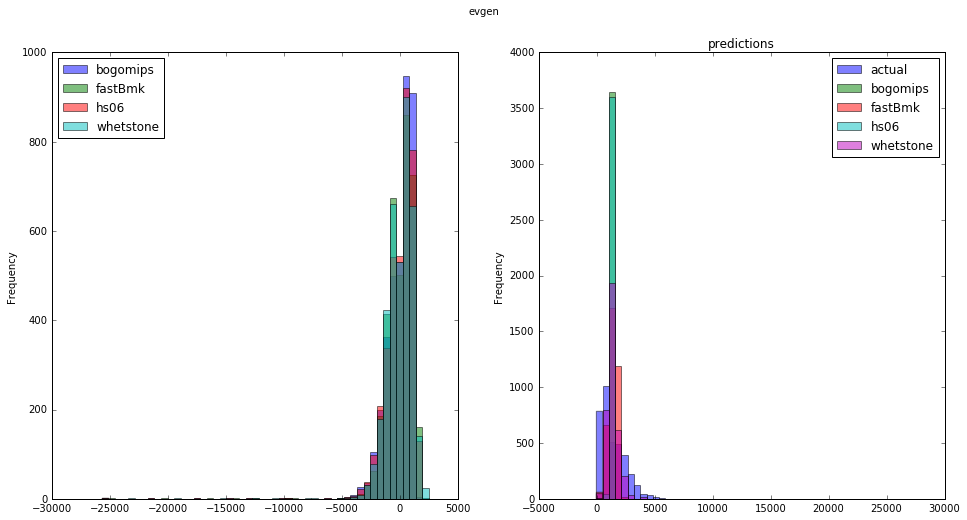

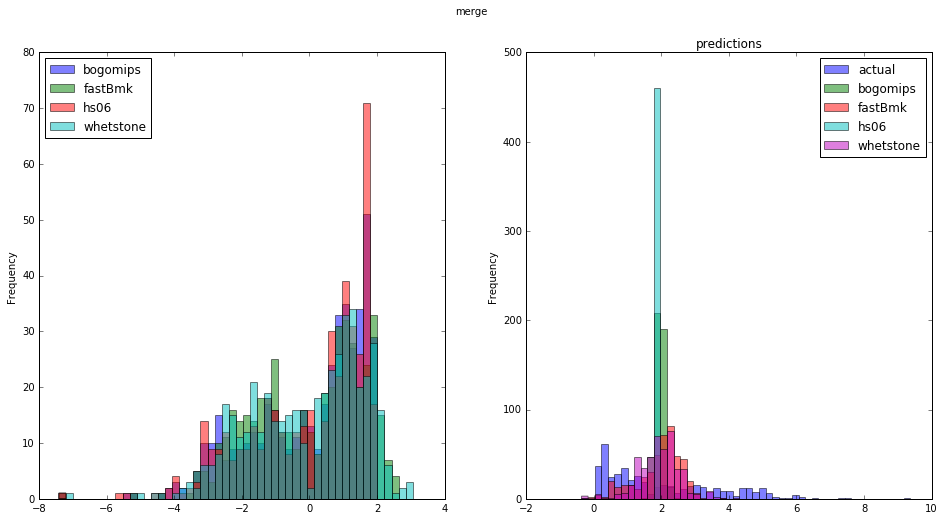

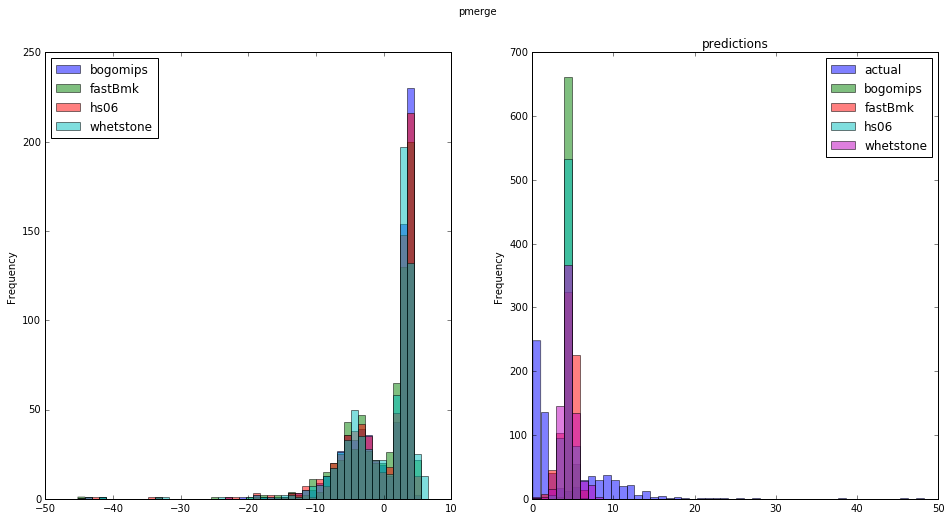

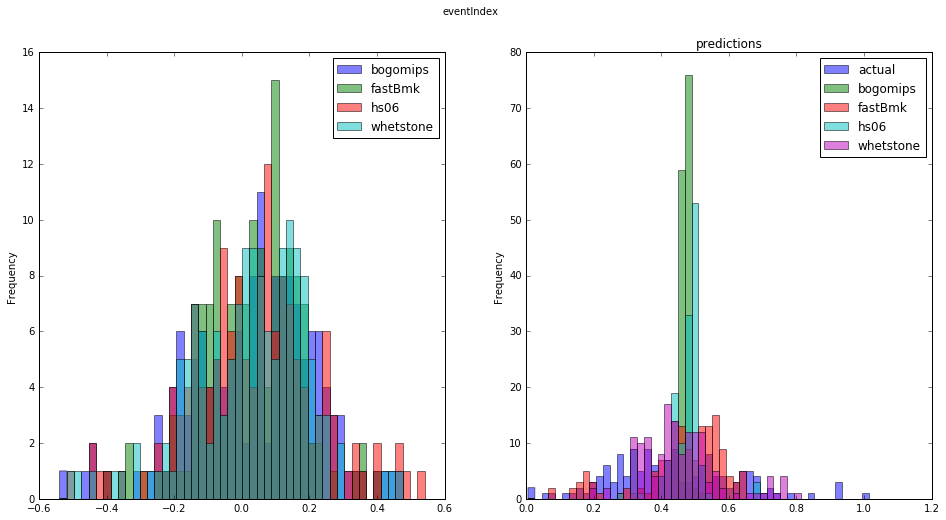

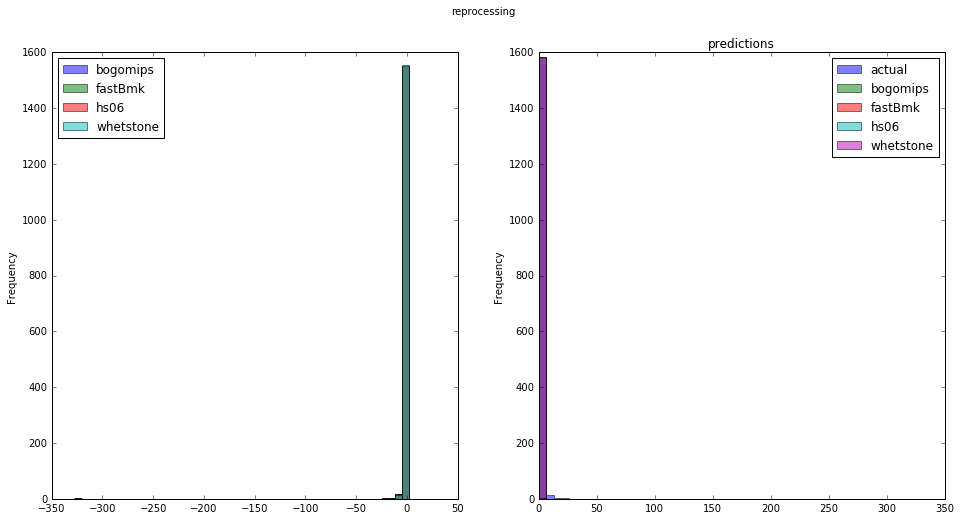

In [8]:
R_mse = {}
R_r2  = {}

#####  LRs ####
lr = LinearRegression()

for pt in ProcessingType:
    print("=========== ",pt,"=============")
    data = ProcessingType[pt]
    tmse=[]
    tr2=[]
    #target
    y = data['cpuPerMB'].copy()
    y = y.values.reshape(-1, 1)
    #print(data['cpuPerEvent'].describe())
    
    X=data.copy()
    del X['cpuPerMB']
    del X['processingtype']
    #print(X.columns)

    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=41)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
    predictions={'actual':y_test.flatten()}
    errors = {}
    
    for f in feat:
        print( "*** ",f," ***")
        
        lm = lr.fit(X_train[f].values.reshape(-1,1), y_train)
        #print ("Linear model:",lm.coef_ , lm.intercept_)
        #hold-out testing
        y_test_predict = lm.predict(X_test[f].values.reshape(-1,1))
        
        # to do cross validation 
        scores = cross_val_score(lr, X[f].values.reshape(-1,1), y, cv=10, scoring='r2')
        print("cross validation score: ", scores.mean())
        #y_test_predict = cross_val_predict(lr, X, y, cv=10)
        
        
        errors[f] = (y_test_predict-y_test).flatten().tolist()
        predictions[f] = y_test_predict.flatten().tolist()
        
        evs = explained_variance_score(y_test, y_test_predict)
        mae = mean_absolute_error(y_test, y_test_predict)
        mse = mean_squared_error(y_test, y_test_predict)
        r2 = r2_score(y_test, y_test_predict) 
        print("\tevs: %2.4f" % evs, "\tmae: {:>10.4f}".format(mae), "\tmse: {:>10.4f}".format(mse), "\tr2:{:>10.4f}".format(r2)) 
        tmse.append(mae)
        tr2.append(r2)
        #print("---------------------------------------")
    
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    plt.suptitle(pt)
    plt.title("errors")
    pl = pd.DataFrame(errors)
    #print("Describe residuals\n", pl.describe())
    pl.plot(ax=axes[0], kind='hist', figsize=(16, 8), bins=50, alpha=0.5) 
    
    pl = pd.DataFrame(predictions)
    plt.title("predictions")
    print("Describe predictions\n", pl.describe())
    pl.plot(ax=axes[1], kind='hist', figsize=(16, 8), bins=50, alpha=0.5) 
        
    ###  based on CPU
    cdata = data.copy()
    del cdata['processingtype']
    del cdata['bogomips']
    del cdata['fastBmk']
    del cdata['whetstone']
    del cdata['hs06']

    cdata_train, cdata_test =  train_test_split( cdata, test_size=0.20, random_state=41)
    print(cdata_train.shape, cdata_test.shape)

    predictions_on_CPU = cdata_train.groupby('cpuname').mean()
    #print(predictions_on_CPU)

    res=[]
    pre=[]
    not_used=0
    for index, row in cdata_test.iterrows():
        cn  = row['cpuname']
        cpe = row['cpuPerMB']
        if cn in predictions_on_CPU.index:
            res.append(cpe)
            pre.append(predictions_on_CPU.loc[cn,'cpuPerMB'])
        else:
            not_used += 1 

    #print(not_used,' test results had CPU not seen in training data.')
        
    #for i in range(len(res)):
    #    print(res[i], pre[i])
    comp=pd.DataFrame({'res':res,'pre':pre})
    #comp

    evs = explained_variance_score(comp.res, comp.pre)
    mae = mean_absolute_error(comp.res, comp.pre)
    mse = mean_squared_error(comp.res, comp.pre)
    r2 = r2_score(comp.res, comp.pre) 
    #print( "%2.4f" % evs, "{:>10.4f}".format(mae), "{:>10.4f}".format(mse), "{:>10.4f}".format(r2)) 
    tmse.append(mae)
    tr2.append(r2)
    R_mse[pt]=tmse
    R_r2[pt]=tr2
    print("---------------------------------------")
        
#print(R_r2)

### plot results

In [9]:
Results=pd.DataFrame(R_r2,index=['bogomips', 'fastBmk', 'whetstone', 'hs06','cpu name'])
Results

,eventIndex,evgen,merge,overlay,pile,pmerge,recon,reprocessing,simul
bogomips,-0.030800,0.000008,0.012221,0.009981,0.004781,0.007370,-0.031110,-0.000022,0.001000
fastBmk,0.416706,0.112583,0.093335,0.282599,0.003255,0.008777,0.046183,0.001007,0.076319
whetstone,0.161686,0.167335,0.036820,0.115124,0.020590,0.024283,0.023040,0.001251,0.089543
hs06,-0.024299,0.009213,-0.000566,0.033886,-0.013724,0.009499,0.122127,0.000466,-0.003297
cpu name,0.326098,0.169987,0.160604,0.258677,-0.214789,0.028192,0.544781,-0.002926,0.383504


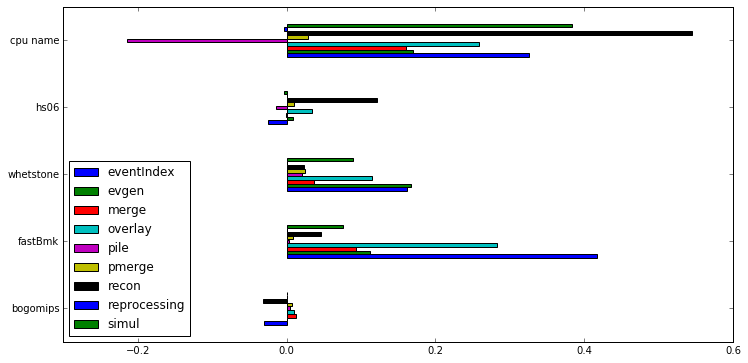

In [10]:
ax = Results.plot(kind='barh',figsize=(12, 6))
ax.get_figure().savefig("benchmarks.png")

In [11]:
Results=pd.DataFrame(R_mse,index=['bogomips', 'fastBmk', 'whetstone', 'hs06','cpu name'])
Results

,eventIndex,evgen,merge,overlay,pile,pmerge,recon,reprocessing,simul
bogomips,0.155692,902.291102,1.423410,35.359649,4.476165,4.169883,6.445778,1.385711,4677.206043
fastBmk,0.115045,867.771701,1.393776,25.682403,4.271949,4.120896,5.882073,1.379027,4558.331090
whetstone,0.136543,854.255182,1.431180,31.463163,4.316624,4.109088,6.120115,1.361759,4416.394302
hs06,0.147411,896.048859,1.428260,35.669753,4.105305,4.145886,5.523901,1.398318,4726.345504
cpu name,0.115817,803.952098,1.244372,25.723637,3.617479,4.004065,3.558572,1.429103,3112.487275


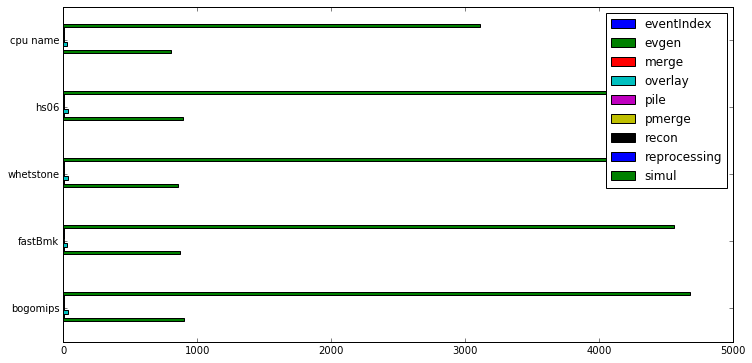

In [12]:
ax = Results.plot(kind='barh',figsize=(12, 6))
ax.get_figure().savefig("benchmarks.png")